In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')#TODO change helper.py file so inharmoniicity is from . and also change midi file so sharedtypes is in lib rather than midi folder
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
import helper


In [2]:
# Return hidden score states 
from librosa import hz_to_note
note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/hymn.midi')
dic = notes_to_chords(note_info, sustain=False)
score, time_to_next, cumulative= dict_to_frequency_list(dic)

    

In [60]:
print(score)

[[440, 349, 294, 294], [262], [349, 587, 294, 233], [392, 330], [523, 440, 349, 220], [294, 466, 392, 196], [330], [440, 349, 262, 175], [349, 392, 294, 117], [330, 262, 131], [440, 349, 262, 175], [659, 440, 330, 139], [698, 440, 147, 330], [165], [698, 440, 175, 294], [196], [659, 440, 294, 220], [587], [440, 659, 277, 110], [392], [587, 349, 220, 147], [440, 349, 294, 294], [262], [349, 587, 294, 233], [392, 330], [523, 440, 349, 220], [294, 466, 392, 196], [330], [440, 349, 262, 175], [349, 392, 294, 117], [330, 262, 131], [440, 349, 262, 175], [659, 440, 330, 139], [698, 440, 147, 330], [165], [698, 440, 175, 294], [196], [659, 440, 294, 220], [587], [440, 659, 277, 110], [392], [587, 349, 220, 147], [698, 440, 294, 147], [262], [659, 392, 233, 196], [587], [392, 523, 262, 220], [349], [587, 349, 233, 262], [220], [659, 466, 233, 196], [262], [466, 698, 294, 175], [440, 262], [392, 233], [698, 440, 262, 175], [523, 440, 349, 175], [311], [440, 587, 294, 233], [392], [523, 440, 294

In [3]:
# Create cov_dict

cov_dict = {}
sample_length = 700
sample_rate = 44100
M=9
transition=0.465
v=2.37
sigma_f=1/500000
sigma_n=0.01
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
max_d = 50

for state in score[:100]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=transition, v=v) + sigma_n**2 * np.eye(sample_length)

In [8]:
import IPython.display as ipd
import os
def print_plot_play(x, Fs, text=''):
    """1. Prints information about an audio singal, 2. plots the waveform, and 3. Creates player
    
    Notebook: C1/B_PythonAudio.ipynb
    
    Args: 
        x: Input signal
        Fs: Sampling rate of x    
        text: Text to print
    """
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

In [23]:
import librosa
import time
performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/hymn6.wav'
hop_length = 5000
frame_length=700
audio_stream = librosa.stream(
                path=performance_path,
                block_length=1,
                # TODO hop length parameter didn't seem to be working so this is a current fix
                frame_length=hop_length,
                hop_length=hop_length,
                mono=True,
                fill_value=0,
                duration=60
            )
time.sleep(1)
print(type(audio_stream[0]))
audio_data = []
for audio_frame in audio_stream:
    print(audio_frame[:frame_length])
    audio_data.append(audio_frame)
    time.sleep(1)

TypeError: 'generator' object is not subscriptable

TypeError: 'generator' object is not subscriptable

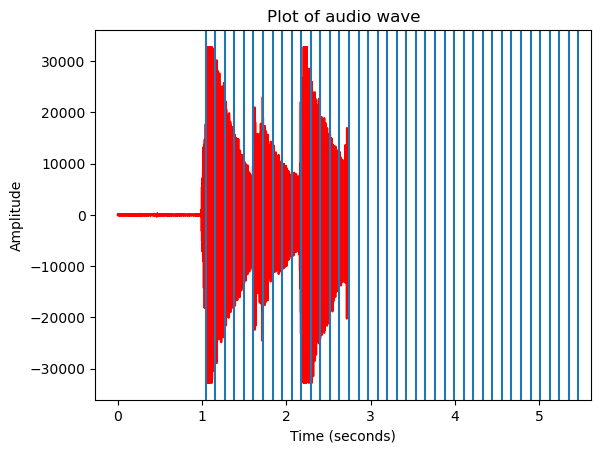

In [77]:

# Return observed state elements as a list of np.arrays called audio_data

# Define arguments


show = 120000
offset = 46000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:40]:
    plt.axvline(i/sample_rate)


In [63]:
p = 1/2.9
q = 1 - p
d = 4
advance_transition = np.sum([q**i * p for i in range(d)])
print(advance_transition)

0.8157436718927837


whole lml values:  -17027209187602.082 1.8977747774091217e+26 32104770883140.35


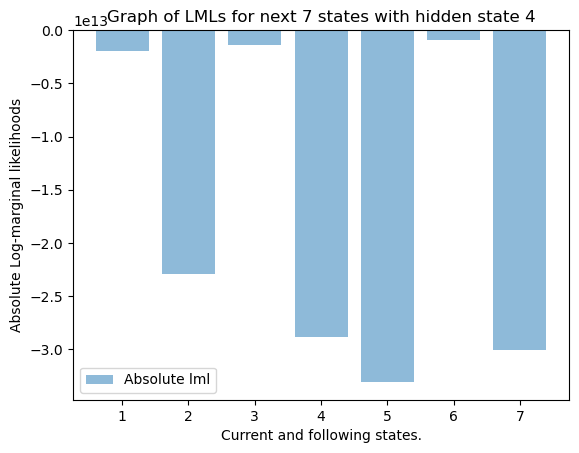

[-4.11635697 -4.65598789 -4.05334945 -4.70956808 -4.74214877 -3.97511709
 -4.71925624]


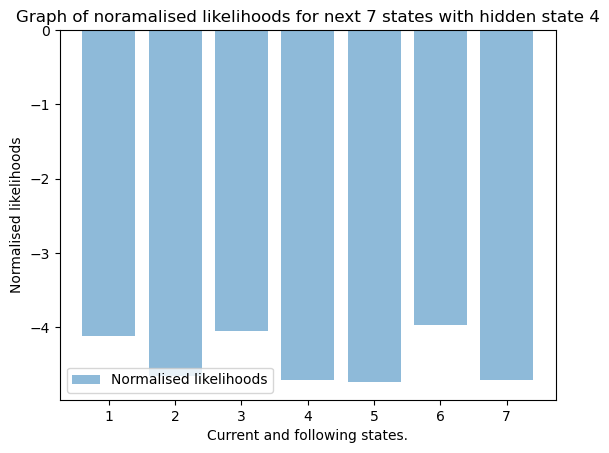

In [64]:
 # Trying by processing methods (not normalisation)

sample_length = len(audio_data[0])
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
freqs = [100, 150, 200, 250, 261, 275,300, 350, 400]
probs = []
probs_data_fit = []
for f in range(len(score[:7])):
    lml = -helper.stable_nlml(time_samples, audio_data[36], M=9, normalised=False, f=score[f], T=0.465, v=2.37)
    lml_data_fit = -helper.relative_nlml(time_samples, audio_data[36], M=9, normalised=False, f=score[f], T=0.465, v=2.37)
    probs.append(lml)
    probs_data_fit.append(lml_data_fit)
# print("data dfit values: ",np.mean(`probs_data_fit`), np.var(probs_data_fit), np.max(probs_data_fit)-np.min(probs_data_fit))
print("whole lml values: ",np.mean(probs), np.var(probs), np.max(probs)-np.min(probs))
# plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Absolute lml Data fit term")
plt.bar([1,2,3,4,5,6,7], probs, alpha=0.5, label="Absolute lml")
plt.legend()

plt.xlabel("Current and following states.")
plt.ylabel("Absolute Log-marginal likelihoods")
plt.title("Graph of LMLs for next 7 states with hidden state 4")
plt.show()



probs = np.sign(probs) * np.abs(probs)**0.05
probs_data_fit =np.sign(probs_data_fit) * np.abs(probs_data_fit)**0.05
# plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Normalised likelihoods Data fit term")
plt.bar([1,2,3,4,5,6,7], probs,alpha=0.5, label="Normalised likelihoods")

plt.xlabel("Current and following states.")
plt.ylabel("Normalised likelihoods")
plt.title("Graph of noramalised likelihoods for next 7 states with hidden state 4")
plt.legend()
print(probs)

data dfit values:  -97380273814546.95 6.701659548694208e+27 200916330147975.38
whole lml values:  -97380273812237.52 6.701659548685136e+27 200916330148053.3


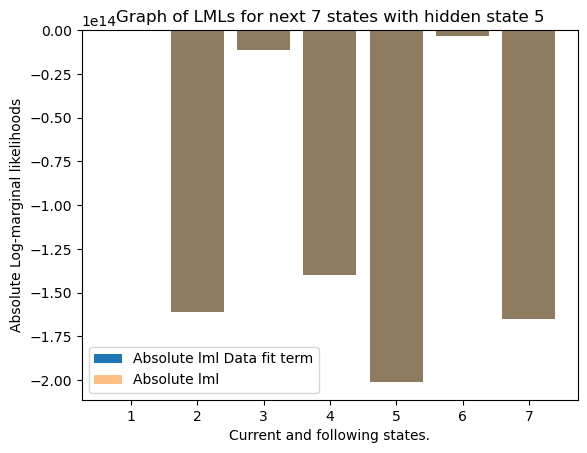

[0.99966419 0.78938906 0.98388431 0.81470129 0.7444715  0.99502667
 0.7851182 ]


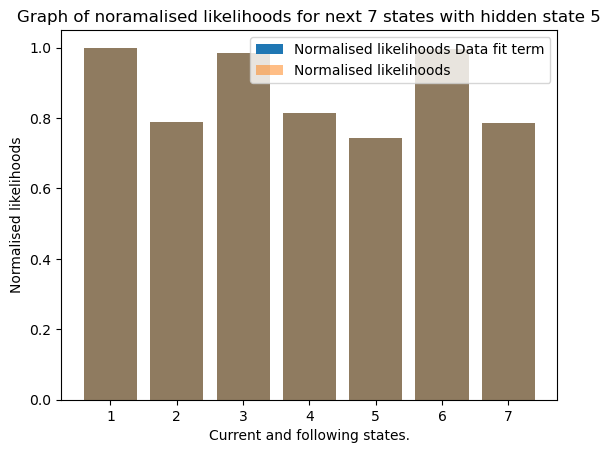

In [65]:
 # Trying by normalisation

sample_length = len(audio_data[0])
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
freqs = [100, 150, 200, 250, 261, 275,300, 350, 400]
probs = []
probs_data_fit = []
for f in range(len(score[:7])):
    lml = -helper.stable_nlml(time_samples, audio_data[2], M=9,   normalised=False, f=score[f], T=0.465, v=2.37)
    lml_data_fit = -helper.relative_nlml(time_samples, audio_data[2], M=9,   normalised=False, f=score[f], T=0.465, v=2.37)
    probs.append(lml)
    probs_data_fit.append(lml_data_fit)
print("data dfit values: ",np.mean(probs_data_fit), np.var(probs_data_fit), np.max(probs_data_fit)-np.min(probs_data_fit))
print("whole lml values: ",np.mean(probs), np.var(probs), np.max(probs)-np.min(probs))
plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Absolute lml Data fit term")
plt.bar([1,2,3,4,5,6,7], probs, alpha=0.5, label="Absolute lml")
plt.legend()

plt.xlabel("Current and following states.")
plt.ylabel("Absolute Log-marginal likelihoods")
plt.title("Graph of LMLs for next 7 states with hidden state 5")

plt.show()
probs = np.exp(np.array(probs)/np.sum(np.abs(probs)))
probs_data_fit = np.exp(np.array(probs_data_fit)/np.sum(np.abs(probs_data_fit)))
plt.bar([1,2,3,4,5,6,7], probs_data_fit, label="Normalised likelihoods Data fit term")
plt.bar([1,2,3,4,5,6,7], probs,alpha=0.5, label="Normalised likelihoods")

plt.xlabel("Current and following states.")
plt.ylabel("Normalised likelihoods")
plt.title("Graph of noramalised likelihoods for next 7 states with hidden state 5")
plt.legend()
print(probs)

In [66]:
lis = np.array([1,2,-3,1])
print(lis**2)


[1 4 9 1]


In [92]:
def viterbi(y: List[np.ndarray], states: List[list], sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    K = len(states) # Number of states
    n = len(y) # Number of audio samples
    gamma = np.full((K, n), -np.inf, 'd') # Matrix to hold probabilities
    delta = np.zeros((K, n), 'B') # Back pointers 
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    max_s = 0
    path = []
    w = 6
    chunk = 0
    step = w //3
    counter = []
    conversion_rate = sample_rate/hop_length # TODO need to make this more general... may eit should depend on the MIDI suggestion...?
    d = 1 # d tracks the duration number (ie this incremements each time we perform a self transition)
    scale_factor = 0.05
    
  
    # Initialise prior state (we will assume we start at the first state)
    # TODO think about the inital state and decide what to do about the silence at first
    lml = -helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[0], T=0.465, v=2.37, cov_dict=cov_dict)
    lml_scaled = np.sign(lml) * np.abs(lml)**scale_factor
    gamma[0, 0] = lml_scaled
    path.append(0)

    advance_transition = np.log(0.5)
    self_transition = np.log(0.5)

    # Iterate through observations
    for i in range(1, n):
        print("audio frame: ", i)

        sum_squared = np.sum(np.array(y[i], dtype=np.int64)**2)
        print(sum_squared)

        
        probs = []

        # Calculate transition probabilities TODO this is way too small relatively
        expected = conversion_rate * time_to_next[max_s]/1000
        p = 1 / expected # probability 
        q = 1 - p
        advance_transition = np.log(0.5)#np.sum([q**z * p for z in range(d)])
        self_transition = np.log(0.5)#np.log(1 - advance_transition)
        # advance_transition = np.log(advance_transition)

        k0_index = chunk * step
        for k in range(k0_index, k0_index + w):

            lml = -helper.stable_nlml(time_samples, y[i], M=9, normalised=False, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)  
            lml_scaled = np.sign(lml) * np.abs(lml)**scale_factor
            probs.append(lml_scaled)
            print("state ", k, "lml ", lml_scaled, "probability of staying the same: ", gamma[k,i-1], "probability of having been the previous: ", gamma[k-1,i-1])

            same_state = lml + gamma[k,i-1] #+ self_transition
            advance_state = lml + gamma[k-1, i-1] #+  advance_transition

            if same_state >= advance_state:
                gamma[k, i] = same_state
                delta[k, i] = k
            else:
                gamma[k, i] = advance_state
                delta[k, i] = k - 1
        
        
        print(gamma[k0_index:k0_index+w,i])
        new_s = np.argmax(gamma[:,i])

        if new_s == max_s:
            d += 1 # increment count 
        else:
            counter.append(d)
            conversion_rates = 1000 * np.array(counter)/ np.array(time_to_next[:len(counter)]) # Multiply by 1000 to make seconds
            conversion_rate =  np.mean(conversion_rates) # Conversion is how many durations counts d per second. We take the running mean average
            d = 1

        max_s = new_s
        print('appending: ', max_s)
        path.append(max_s)

        if max_s >= k0_index + w - step:
            chunk += 1
    
    # Build the optimal path, for comparison to live output
    optimal_path = np.zeros(n, 'B')
    optimal_path[-1] = np.argmax(gamma[:, n-1])

    for i in reversed(range(1, n)):
        optimal_path[i-1] = delta[optimal_path[i], i]

    return path, optimal_path,counter


path, optimal, counter = viterbi(audio_data[:90],  score[:90], cov_dict=cov_dict )
print(path, optimal)

    

audio frame:  1
191752447006
state  0 lml  -4.087954580021511 probability of staying the same:  -4.6372672053166015 probability of having been the previous:  -inf
state  1 lml  -5.45032615552697 probability of staying the same:  -inf probability of having been the previous:  -4.6372672053166015
state  2 lml  -4.801815094494758 probability of staying the same:  -inf probability of having been the previous:  -inf
state  3 lml  -5.569509054194067 probability of staying the same:  -inf probability of having been the previous:  -inf
state  4 lml  -5.536095885592612 probability of staying the same:  -inf probability of having been the previous:  -inf
state  5 lml  -4.531457247249714 probability of staying the same:  -inf probability of having been the previous:  -inf
[-1.69871780e+12 -5.35118342e+14            -inf            -inf
            -inf            -inf]
appending:  0
audio frame:  2
109722742460
state  0 lml  -3.9569670886483506 probability of staying the same:  -1698717797338.490

In [91]:
print(sum_squared)

NameError: name 'sum_squared' is not defined

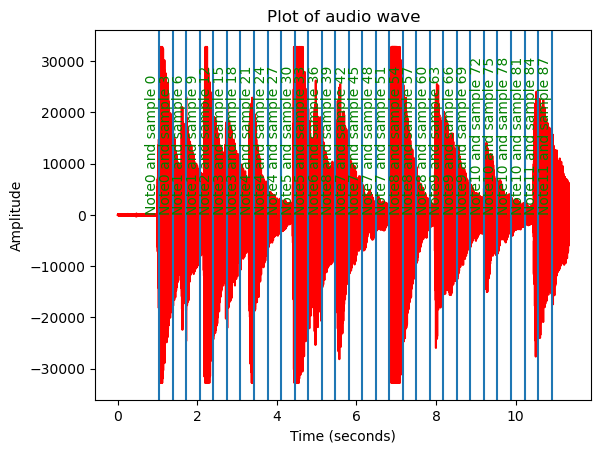

In [90]:
time_samples = np.linspace(0, performance_duration, len(data))
show = 500000
# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for _, i in enumerate(sample_indices[:89]):
    if _ %3 == 0:
        plt.axvline(i/sample_rate)
        plt.text(sample_indices[_]/sample_rate, 0.3, f'Note{path[_]} and sample {_}', color='green', ha='right', va='bottom', rotation=90, fontsize=10)
    

In [70]:
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
i=6
j=23
print(-helper.stable_nlml(time_samples, audio_data[j], M=9, normalised=False, f=[294, 466, 392, 196], T=0.465, v=2.37, cov_dict=cov_dict ))
print(-helper.stable_nlml(time_samples, audio_data[j], M=9, normalised=False, f=[330], T=0.465, v=2.37, cov_dict=cov_dict ))
print(-helper.stable_nlml(time_samples, audio_data[j], M=9, normalised=False, f=[ 330,294, 466, 392, 196], T=0.465, v=2.37, cov_dict=cov_dict ))

-20030996368211.547
-13371025069322.715
-69529784658.65541


In [71]:
freqs = np.linspace(100, 800, 1000)
probs = []
for freq in freqs:
    probs.append(-helper.stable_nlml(time_samples, audio_data[j], M=9, normalised=False, f=[freq], T=0.465, v=2.37, cov_dict=cov_dict ))

KeyboardInterrupt: 

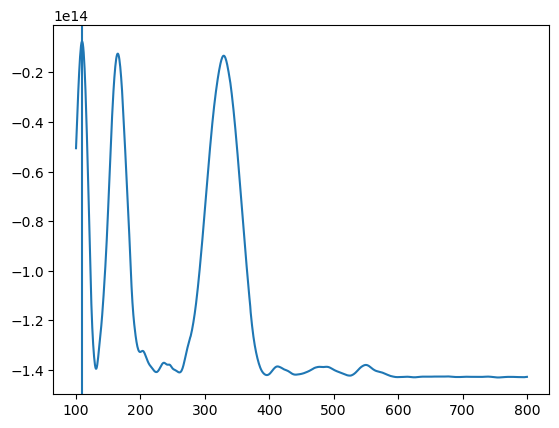

In [ ]:
plt.plot(freqs, probs)
plt.axvline(110)

In [ ]:
print(score[:8])
score[3] = [262, 330, 392, 523]

[[440, 349, 294, 294], [349, 440, 294, 262], [349, 587, 294, 233], [587, 233, 392, 330], [523, 440, 349, 220], [294, 466, 392, 196], [330, 392, 466, 196], [440, 349, 262, 175]]


In [ ]:
# Create cov_dict

cov_dict = {}
sample_length = 1000
sample_rate = 44100
M=9
transition=0.465
v=2.37
sigma_f=1/500000
sigma_n=100
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
max_d = 50

for state in score[:10]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=transition, v=v) + sigma_n**2 * np.eye(sample_length)

In [ ]:
lml.append(-helper.stable_nlml(time_samples, audio_data[20], M=9, normalised=False, f=score[5], T=0.465, v=2.37, cov_dict=cov_dict, amplitude=[])  )

[[440, 349, 294, 294], [262], [349, 587, 294, 233], [392, 330], [523, 440, 349, 220], [294, 466, 392, 196], [330], [440, 349, 262, 175], [349, 392, 294, 117], [330, 262, 131], [440, 349, 262, 175], [659, 440, 330, 139], [698, 440, 147, 330], [165], [698, 440, 175, 294], [196], [659, 440, 294, 220], [587], [440, 659, 277, 110], [392], [587, 349, 220, 147], [440, 349, 294, 294], [262], [349, 587, 294, 233], [392, 330], [523, 440, 349, 220], [294, 466, 392, 196], [330], [440, 349, 262, 175], [349, 392, 294, 117], [330, 262, 131], [440, 349, 262, 175], [659, 440, 330, 139], [698, 440, 147, 330], [165], [698, 440, 175, 294], [196], [659, 440, 294, 220], [587], [440, 659, 277, 110], [392], [587, 349, 220, 147], [698, 440, 294, 147], [262], [659, 392, 233, 196], [587], [392, 523, 262, 220], [349], [587, 349, 233, 262], [220], [659, 466, 233, 196], [262], [466, 698, 294, 175], [440, 262], [392, 233], [698, 440, 262, 175], [523, 440, 349, 175], [311], [440, 587, 294, 233], [392], [523, 440, 294

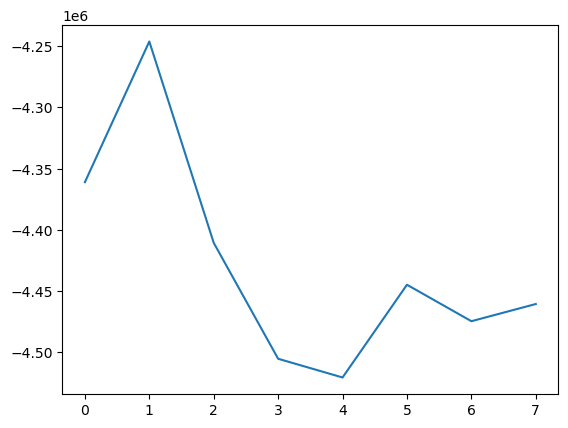

In [ ]:
# # helper.plot_fft(audio_data[7])

# print(score[2])
# plt.axvline(349)
# plt.axvline(587)
# plt.axvline(294)
# plt.axvline(233)
print(score)
lml = []
for i in range(8):
    lml.append(-helper.stable_nlml(time_samples, audio_data[9], M=9, normalised=False, f=score[i], T=0.465, v=2.37, cov_dict=cov_dict)  )
plt.plot(lml)

In [ ]:
print(-helper.stable_nlml(time_samples, audio_data[3], M=8, normalised=False, f=[262], T=0.465, v=2.37, cov_dict=cov_dict) )
print(-helper.stable_nlml(time_samples, audio_data[3], M=8, normalised=False, f=[440, 349, 294, 294], T=0.465, v=2.37, cov_dict=cov_dict) )

-2920551.7250153376
-2884226.928814967


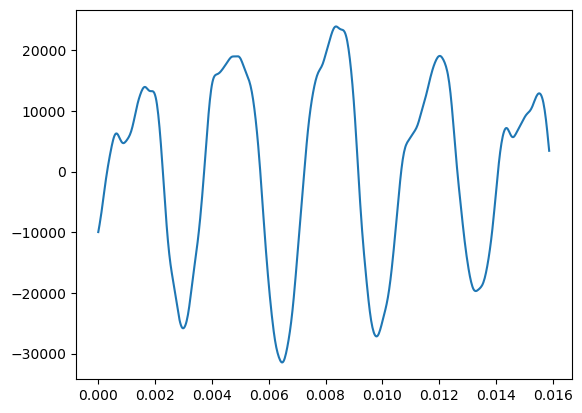

In [ ]:
time_samples = np.linspace(0, len(audio_data[0])/sample_rate, sample_length)
plt.plot(time_samples,audio_data[7])


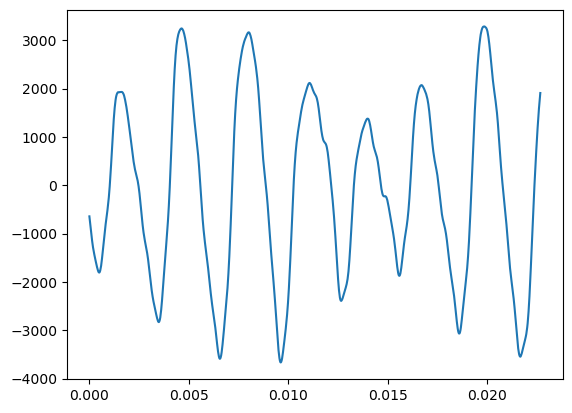

In [ ]:
plt.plot(time_samples,audio_data[5])